In [2]:
%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import statsmodels.api as sm
from scipy.stats import pearsonr, spearmanr
from scipy import stats
from IPython.display import display, HTML
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, auc, classification_report
from sklearn.model_selection import train_test_split
from datetime import datetime
from statsmodels.formula.api import ols
from statsmodels.stats.api import anova_lm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.feature_selection import mutual_info_regression
from sklearn.feature_selection import VarianceThreshold
from sklearn.preprocessing import LabelEncoder

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)
pd.set_option('display.expand_frame_repr', False)
pd.set_option('display.precision', 3)
import warnings
warnings.filterwarnings('ignore')



In [3]:
#loading the dataset

train_df = pd.read_csv('data/train_trustpilot_3.csv', engine='python')
df_trustpilot = pd.read_csv('data/data_trustpilot_3.csv', engine='python')
test_df = pd.read_csv('data/test_trustpilot_3.csv', engine='python')

display(train_df.head())



,rating,location,username,verification,repeat_reviewer_encoded,company,subject,text,answer,answered,local_date_posted,month_posted,local_hour,time_of_day,day_of_week_posted,day_type,review_time
0,5,US,Mark Bock,1,0,Flashbay,Great work,"Great experience all around working with Flashbay. I was very impressed from the start -- the sample box they send to display the various styles of flash drives is ingeniously designed, and having actual samples of the styles helped a lot. My initial thought was that we would just go with the least expensive option, but everyone at my company liked one of the higher end options so much after handling it that we ended up going with that. \r Our account manager, Samantha, was very easy to work with and quickly answered all questions, and once our management gave the green light to place the order, she got it into production immediately, and the finished drives arrived a day ahead of schedule. And the end product looks outstanding. All of us here are very pleased.\r Consider me very impressed. I wish all vendors were this pleasant to work with.","Hi Mark,We are glad you found the sample pack useful in making your selection. It is also great to hear that Samantha was able to answer all of your questions, and you are happy with the final product.We look forward to working with you next time!-Flashbay Management",1,2016-02-09,2,11,3,1,1,1
1,5,US,Walt,1,1,Quicken,Works as it should.,Works as it should.,0,0,2024-04-03,4,8,1,2,1,1
2,3,US,David Banoff,1,0,Quicken,Earlier versions of Quicken saved the…,"Earlier versions of Quicken saved the most recent values for entries and presented them the next time (e.g. categories. amounts). Quicken no longer does this, but it still presents the previous entries when a payee, for example, created under the older version is used again. This creates more editing than necessary.",0,0,2023-01-16,1,13,3,0,1,0
3,5,US,Sheri - March Of Dimes,1,0,Flashbay,"Great Customer Service, Super Fast Turn",Extremely communicative sales rep (Mike Dods) - responsive and helpful through the entire order process. Product arrived quickly and exactly as ordered. We will definitely use Flashbay again without hesitation should the need arise.,"Hi Sheri,Thank you for your kind words.It’s great to hear that Mike was so helpful throughout the ordering process. I will make sure to pass this along to him.We appreciate your business, and look forward to working with you next time! -Flashbay Management",1,2015-05-01,5,16,3,4,1,1
4,5,NL,Pascal,1,1,SteelSeries,Great product,"Great product, great after sales!",0,0,2021-12-03,12,20,2,4,1,1


In [4]:
#First check
train_df['local_date_posted'] = pd.to_datetime(train_df['local_date_posted'])

print(train_df.columns)
display(train_df.info())

Index(['rating', 'location', 'username', 'verification',
       'repeat_reviewer_encoded', 'company', 'subject', 'text', 'answer',
       'answered', 'local_date_posted', 'month_posted', 'local_hour',
       'time_of_day', 'day_of_week_posted', 'day_type', 'review_time'],
      dtype='object')
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62723 entries, 0 to 62722
Data columns (total 17 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   rating                   62723 non-null  int64         
 1   location                 62723 non-null  object        
 2   username                 62720 non-null  object        
 3   verification             62723 non-null  int64         
 4   repeat_reviewer_encoded  62723 non-null  int64         
 5   company                  62723 non-null  object        
 6   subject                  62723 non-null  object        
 7   text                     62723 non-null  o

None

STAGE 1 - HEATMAP & MULTICOLLINEARITY

In [5]:
#Split set into numeric, categorical and datetime variables
#Provide statistical metrics for numeric variables

numeric_variables = train_df.select_dtypes(include = ['int', 'float'])
categorical_variables = train_df.select_dtypes(include=['object']) 
datetime_variables = train_df.select_dtypes(include=['datetime64'])

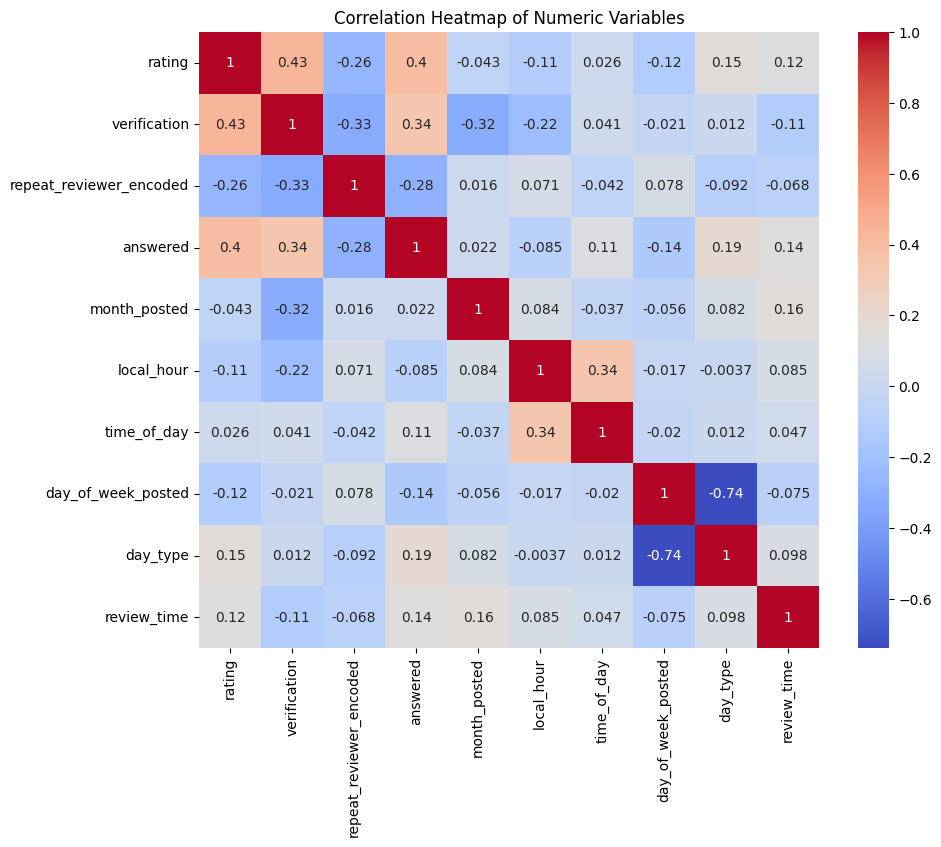

Highly correlated pairs (>0.7) with analysis:
day_type & day_of_week_posted: -0.738
Correlation with rating: day_type: 0.151, day_of_week_posted: 0.119
Recommendation: Keep day_type (stronger correlation with target)


In [6]:
# Correlation heatmap for numeric variables
plt.figure(figsize=(10, 8))
correlation_matrix = numeric_variables.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap of Numeric Variables')
plt.show()

print("Highly correlated pairs (>0.7) with analysis:")
for i in range(len(correlation_matrix.columns)):
    for j in range(i):
        if abs(correlation_matrix.iloc[i, j]) > 0.7:
            var1 = correlation_matrix.columns[i]
            var2 = correlation_matrix.columns[j]
            correlation = correlation_matrix.iloc[i, j]
            
            corr_with_target1 = abs(correlation_matrix.loc[var1, 'rating'])
            corr_with_target2 = abs(correlation_matrix.loc[var2, 'rating'])
            
            print(f"{var1} & {var2}: {correlation:.3f}")
            print(f"Correlation with rating: {var1}: {corr_with_target1:.3f}, {var2}: {corr_with_target2:.3f}")
            print(f"Recommendation: Keep {var1 if corr_with_target1 > corr_with_target2 else var2} "
                  f"(stronger correlation with target)")

STAGE 2 - PEARSON AND SPEARMAN

In [7]:
#Pearson and Spearman

def analyze_correlation_with_rating(column_name):
    if column_name not in train_df.columns:
        return f"Error: Column '{column_name}' not found in dataframe"
    
    # Calculate correlations
    pearson_coeff, pearson_p = pearsonr(train_df['rating'], train_df[column_name])
    spearman_coeff, spearman_p = spearmanr(train_df['rating'], train_df[column_name])
    
    # Format output
    output = []
    output.append(f"Correlation Analysis: rating vs {column_name}")
    output.append("=" * 50)
    output.append("Hypothesis:")
    output.append("H0: The two variables are uncorrelated")
    output.append("H1: The two variables are correlated")
    output.append("Results:")
    output.append("-" * 50)
    
    # Pearson Analysis
    output.append(f"Pearson coefficient: {pearson_coeff}")
    if abs(pearson_coeff) < 0.1:
        strength = "extremely weak/negligible"
    elif abs(pearson_coeff) < 0.3:
        strength = "weak"
    elif abs(pearson_coeff) < 0.5:
        strength = "moderate"
    else:
        strength = "strong"
    direction = "negative" if pearson_coeff < 0 else "positive"
    output.append(f"Negative sign indicates an inverse relationship but as the value is {strength}, "
                 f"this indicates a{strength} {direction} correlation.")
    
    output.append(f"Pearson p_value: {pearson_p}")
    if pearson_p < 0.05:
        output.append("Value is smaller than the common significance level of 0.05. "
                     f"This indicates that the correlation, although {strength}, is statistically significant.")
    else:
        output.append("Value is larger than the common significance level of 0.05. "
                     "This indicates that the correlation is not statistically significant.")
    
    # Spearman Analysis
    output.append(f"Spearman coefficient: {spearman_coeff}")
    if abs(spearman_coeff) < 0.1:
        strength = "extremely weak/negligible"
    elif abs(spearman_coeff) < 0.3:
        strength = "weak"
    elif abs(spearman_coeff) < 0.5:
        strength = "moderate"
    else:
        strength = "strong"
    output.append(f"Negative sign indicates an inverse relationship and as the value is {strength}, "
                 f"this indicates a {strength} {direction} correlation.")
    
    output.append(f"Spearman p_value: {spearman_p}")
    if spearman_p < 0.05:
        output.append("Value is smaller than the common significance level of 0.05. "
                     f"This indicates that the correlation, although {strength}, is statistically significant.")
    else:
        output.append("Value is larger than the common significance level of 0.05. "
                     "This indicates that the correlation is not statistically significant.")
    
    # Conclusion
    output.append("Conclusion:")
    output.append("-" * 50)
    if pearson_p < 0.05 or spearman_p < 0.05:
        output.append("H0 is rejected")
        output.append("H1 is confirmed")
    else:
        output.append("Failed to reject H0")
        
    # Additional insights
    if abs(abs(spearman_coeff) - abs(pearson_coeff)) > 0.1:
        output.append(f"The difference between Pearson ({pearson_coeff:.3f}) and "
                     f"Spearman ({spearman_coeff:.3f}) suggests a non-linear relationship")
    
    # Practical interpretation
    output.append(f"As {column_name} increases, ratings tend to "
                 f"{'decrease' if pearson_coeff < 0 else 'increase'}")
    output.append("While statistically significant, the relationship is "
                 f"{strength}")
    output.append("Keep for model training of a rating model")
    
    return "".join(output)


# Get list of numeric columns excluding 'rating'
numeric_columns = train_df.select_dtypes(include=['int64', 'float64']).columns
numeric_columns = [col for col in numeric_columns if col != 'rating']

print("Starting correlation analysis for all numeric variables...")
print("=" * 80)

# Loop through each numeric column
for column in numeric_columns:
    display(HTML(f"<pre>{analyze_correlation_with_rating(column)}</pre>"))
    display(HTML("<hr>")) 


Starting correlation analysis for all numeric variables...


STAGE 3 - MUTUAL INFORMATION

In [8]:
def analyze_mutual_information_with_rating(column_name):
    if column_name not in train_df.columns:
        return f"Error: Column '{column_name}' not found in dataframe"
    
    # Calculate mutual information
    mi_score = mutual_info_regression(train_df[[column_name]], train_df['rating'], random_state=42)[0]
    
    # Format output
    output = []
    output.append(f"Mutual Information Analysis: rating vs {column_name}")
    output.append("=" * 50)
    output.append("Interpretation:")
    output.append("Mutual Information measures the dependency between variables (including non-linear relationships)")
    output.append("Score ranges from 0 (no mutual information) to ln(n_classes) (perfect mutual information)")
    output.append("Results:")
    output.append("-" * 50)
    
    # MI Analysis
    output.append(f"Mutual Information score: {mi_score:.4f}")
    if mi_score < 0.01:
        strength = "extremely weak/negligible"
    elif mi_score < 0.05:
        strength = "weak"
    elif mi_score < 0.2:
        strength = "moderate"
    else:
        strength = "strong"
    
    output.append(f"This indicates a {strength} dependency between {column_name} and rating")
    
    # Conclusion
    output.append("Conclusion:")
    output.append("-" * 50)
    if mi_score > 0.01:
        output.append(f"There is a {strength} statistical dependency between {column_name} and rating")
        output.append("Feature could be valuable for predictive modeling")
    else:
        output.append("There is negligible statistical dependency between the variables")
        output.append("Consider dropping this feature for modeling")
    
    return "".join(output)

# Get list of numeric columns excluding 'rating'
numeric_columns = train_df.select_dtypes(include=['int64', 'float64']).columns
numeric_columns = [col for col in numeric_columns if col != 'rating']

print("Starting mutual information analysis for all numeric variables...")
print("=" * 80)

# Loop through each numeric column
for column in numeric_columns:
    display(HTML(f"<pre>{analyze_mutual_information_with_rating(column)}</pre>"))
    display(HTML("<hr>"))

Starting mutual information analysis for all numeric variables...


STAGE 4 - ANOVA

In [9]:
#ANOVA

def analyze_anova_with_rating(df):
    attributes = df.select_dtypes(include=['int64', 'float64']).columns
    attributes = [col for col in attributes if col != 'rating']
    
    # Store results and selected features
    results = {}
    feat_select = []
    
    print("ANOVA Analysis: Features vs Rating")
    print("=" * 50)
    
    # Analyze each feature
    for feature in attributes:
        try:
            lm = ols('rating ~ {}'.format(feature), data=df).fit()
            table = anova_lm(lm)
            p_value = table['PR(>F)'].iloc[0]
            
            # If significant, add to selected features
            if p_value <= 0.05:
                feat_select.append(feature)
                results[feature] = p_value
                
        except Exception as e:
            print(f"Error analyzing {feature}: {str(e)}")
    
    # Create and display results table
    if feat_select:
        results_df = pd.DataFrame({
            'Feature': feat_select,
            'P-value': [results[f] for f in feat_select]
        }).sort_values('P-value')
        
        print("Selected Features (p ≤ 0.05):")
        print(results_df)
    
    return feat_select

selected_features = analyze_anova_with_rating(train_df)

ANOVA Analysis: Features vs Rating
Selected Features (p ≤ 0.05):
                   Feature     P-value
0             verification   0.000e+00
1  repeat_reviewer_encoded   0.000e+00
2                 answered   0.000e+00
7                 day_type  4.387e-318
8              review_time  1.224e-213
6       day_of_week_posted  2.473e-196
4               local_hour  2.367e-155
3             month_posted   5.445e-27
5              time_of_day   3.958e-11


In [10]:
#ANOVA 

def analyze_anova_with_rating(df):
    attributes = df.select_dtypes(include=['int64', 'float64']).columns
    attributes = [col for col in attributes if col != 'rating']
    
    results = {}
    feat_select = []
    output_text = []
    
    output_text.append("ANOVA Analysis: Features vs Rating")
    output_text.append("=" * 50)
    
    for feature in attributes:
        try:
            lm = ols('rating ~ {}'.format(feature), data=df).fit()
            table = anova_lm(lm)
            p_value = table['PR(>F)'].iloc[0]
            f_stat = table['F'].iloc[0]
            
            # Calculate effect size (eta-squared)
            ss_between = table['sum_sq'][0]
            ss_total = ss_between + table['sum_sq'][1]
            eta_squared = ss_between / ss_total
            
            # Store results
            results[feature] = {
                'p_value': p_value,
                'f_stat': f_stat,
                'eta_squared': eta_squared
            }
            
            # Interpret effect size
            if eta_squared < 0.01:
                effect_strength = "negligible"
            elif eta_squared < 0.06:
                effect_strength = "small"
            elif eta_squared < 0.14:
                effect_strength = "medium"
            else:
                effect_strength = "large"
            
            # Feature selection
            if p_value <= 0.05:
                feat_select.append(feature)
            
            # Output for each feature
            output_text.append(f"Analysis for: {feature}")
            output_text.append("-" * 30)
            output_text.append(f"F-statistic: {f_stat:.4f}")
            output_text.append(f"P-value: {p_value:.4e}")
            output_text.append(f"Effect size (η²): {eta_squared:.4f}")
            output_text.append(f"Effect strength: {effect_strength}")
            output_text.append(f"Selected for model: {'Yes' if p_value <= 0.05 else 'No'}")
            
        except Exception as e:
            output_text.append(f"Error analyzing {feature}: {str(e)}")
    
    output_text.append("" + "=" * 50)
    output_text.append("Summary:")
    output_text.append(f"Total features analyzed: {len(attributes)}")
    output_text.append(f"Features selected: {len(feat_select)}")
    output_text.append("Selected features:")
    for feat in feat_select:
        p_value = results[feat]['p_value']
        eta = results[feat]['eta_squared']
        output_text.append(f"- {feat}: p={p_value:.4e}, η²={eta:.4f}")
    
    print("".join(output_text))
    return results, feat_select

results, selected_features = analyze_anova_with_rating(train_df)

ANOVA Analysis: Features vs Rating==================================================Analysis for: verification------------------------------F-statistic: 14570.6791P-value: 0.0000e+00Effect size (η²): 0.1885Effect strength: largeSelected for model: YesAnalysis for: repeat_reviewer_encoded------------------------------F-statistic: 4531.3489P-value: 0.0000e+00Effect size (η²): 0.0674Effect strength: mediumSelected for model: YesAnalysis for: answered------------------------------F-statistic: 11640.0522P-value: 0.0000e+00Effect size (η²): 0.1565Effect strength: largeSelected for model: YesAnalysis for: month_posted------------------------------F-statistic: 115.8383P-value: 5.4447e-27Effect size (η²): 0.0018Effect strength: negligibleSelected for model: YesAnalysis for: local_hour------------------------------F-statistic: 709.0493P-value: 2.3666e-155Effect size (η²): 0.0112Effect strength: smallSelected for model: YesAnalysis for: time_of_day------------------------------F-statistic: 43.649

STAGE 5 - VARIANCE THRESHOLD

In [11]:
#Variance Threshold

def analyze_variance_threshold(threshold=0.0):
   # Get numeric columns only
   numeric_data = train_df.select_dtypes(include=['int64', 'float64'])
   
   # Calculate variance for each feature
   variances = numeric_data.var()
   
   output = []
   output.append("Variance Threshold Analysis")
   output.append("=" * 50)
   output.append("Feature Variances:")
   output.append("-" * 50)
   
   # Sort variances in descending order
   sorted_variances = variances.sort_values(ascending=False)
   for feature, var in sorted_variances.items():
       output.append(f"{feature}: {var:.6f}")
       if var <= threshold:
           output.append(f"WARNING: {feature} has variance <= {threshold}")
   
   # Identify low variance features
   low_variance_features = variances[variances <= threshold].index.tolist()
   
   output.append("Conclusion:")
   output.append("-" * 50)
   if low_variance_features:
       output.append(f"Features with variance <= {threshold}:")
       for feature in low_variance_features:
           output.append(f"- {feature}")
       output.append("Consider removing these low-variance features")
   else:
       output.append(f"All features have variance > {threshold}")
   
   return "".join(output)

display(HTML(f"<pre>{analyze_variance_threshold(threshold=0.01)}</pre>"))

STAGE 6 - FISHER SCORE

In [12]:
def analyze_fisher_score():
    # Get numeric features excluding the target
    numeric_data = train_df.select_dtypes(include=['int64', 'float64'])
    numeric_features = [col for col in numeric_data.columns if col != 'rating']
    
    # Function to calculate Fisher score for a single feature
    def calculate_fisher_score(feature):
        # Calculate mean and variance for each class
        class_stats = train_df.groupby('rating').agg({
            feature: ['mean', 'var', 'count']
        })[feature]
        
        # Overall mean of the feature
        overall_mean = train_df[feature].mean()
        
        # Calculate between-class and within-class variance
        between_class = sum(class_stats['count'] * (class_stats['mean'] - overall_mean) ** 2)
        within_class = sum((class_stats['count'] - 1) * class_stats['var'])
        
        # Fisher score is between-class variance divided by within-class variance
        if within_class == 0:
            return 0  # To handle division by zero
        return between_class / within_class
    
    # Calculate Fisher scores for all features
    fisher_scores = {}
    for feature in numeric_features:
        fisher_scores[feature] = calculate_fisher_score(feature)
    
    # Sort scores in descending order
    sorted_scores = sorted(fisher_scores.items(), key=lambda x: x[1], reverse=True)
    
    # Prepare output
    output = []
    output.append("Fisher Score Analysis")
    output.append("=" * 50)
    output.append("Feature Scores (sorted by discriminative power):")
    output.append("-" * 50)
    
    # Add interpretation based on score magnitude
    for feature, score in sorted_scores:
        if score > 1.0:
            strength = "strong"
        elif score > 0.5:
            strength = "moderate"
        elif score > 0.1:
            strength = "weak"
        else:
            strength = "very weak"
            
        output.append(f"{feature}: {score:.6f} ({strength} discriminative power)")
    
    output.append("Interpretation:")
    output.append("-" * 50)
    output.append("Higher Fisher scores indicate better discriminative power for rating prediction")
    output.append("• Strong: > 1.0")
    output.append("• Moderate: 0.5 - 1.0")
    output.append("• Weak: 0.1 - 0.5")
    output.append("• Very weak: < 0.1")
    
    output.append("Recommendations:")
    output.append("-" * 50)
    weak_features = [feature for feature, score in sorted_scores if score < 0.1]
    if weak_features:
        output.append("Consider removing these features with very weak discriminative power:")
        for feature in weak_features:
            output.append(f"- {feature}")
    
    return "".join(output)

display(HTML(f"<pre>{analyze_fisher_score()}</pre>"))

STAGE 7 - MEAN ABSOLUTE DIFFERENCE

In [13]:
def analyze_mean_absolute_difference():
   # Get numeric features excluding the target
   numeric_data = train_df.select_dtypes(include=['int64', 'float64'])
   numeric_features = [col for col in numeric_data.columns if col != 'rating']
   
   # Function to calculate MAD for a single feature
   def calculate_mad(feature):
       feature_mean = train_df[feature].mean()
       mad = (train_df[feature] - feature_mean).abs().mean()
       return mad
   
   # Calculate MAD for all features
   mad_scores = {}
   for feature in numeric_features:
       mad_scores[feature] = calculate_mad(feature)
   
   # Sort scores in descending order
   sorted_scores = sorted(mad_scores.items(), key=lambda x: x[1], reverse=True)
   
   # Prepare output
   output = []
   output.append("Mean Absolute Difference Analysis")
   output.append("=" * 50)
   output.append("Feature MAD Scores (sorted by variability):")
   output.append("-" * 50)
   
   # Calculate mean MAD for threshold reference
   mean_mad = np.mean(list(mad_scores.values()))
   
   # Add interpretation for each feature
   for feature, score in sorted_scores:
       if score > 2 * mean_mad:
           variability = "high"
       elif score > mean_mad:
           variability = "moderate"
       else:
           variability = "low"
           
       output.append(f"{feature}: {score:.6f} ({variability} variability)")
   
   output.append("Interpretation:")
   output.append("-" * 50)
   output.append("MAD measures the average absolute deviation from the mean")
   output.append(f"Average MAD across features: {mean_mad:.6f}")
   output.append("• High variability: > 2x average MAD")
   output.append("• Moderate variability: > average MAD")
   output.append("• Low variability: ≤ average MAD")
   
   output.append("Recommendations:")
   output.append("-" * 50)
   low_var_features = [feature for feature, score in sorted_scores if score <= mean_mad/2]
   if low_var_features:
       output.append("Consider investigating these features with very low variability:")
       for feature in low_var_features:
           output.append(f"- {feature}")
   
   return "".join(output)

display(HTML(f"<pre>{analyze_mean_absolute_difference()}</pre>"))

STAGE 8 - DISPERSION RATIO

In [14]:
def analyze_dispersion_ratio():
   # Get numeric features excluding the target
   numeric_data = train_df.select_dtypes(include=['int64', 'float64'])
   numeric_features = [col for col in numeric_data.columns if col != 'rating']
   
   # Function to calculate dispersion ratio for a single feature
   def calculate_dispersion_ratio(feature):
       # Calculate dispersion (variance) for each rating group
       group_vars = train_df.groupby('rating')[feature].var()
       # Calculate overall variance
       total_var = train_df[feature].var()
       # Dispersion ratio is max group variance / min group variance
       if group_vars.min() == 0:
           return float('inf')  # Handle division by zero
       return group_vars.max() / group_vars.min()
   
   # Calculate dispersion ratios for all features
   dispersion_ratios = {}
   for feature in numeric_features:
       dispersion_ratios[feature] = calculate_dispersion_ratio(feature)
   
   # Sort ratios in descending order
   sorted_ratios = sorted(dispersion_ratios.items(), key=lambda x: x[1], reverse=True)
   
   # Prepare output
   output = []
   output.append("Dispersion Ratio Analysis")
   output.append("=" * 50)
   output.append("Feature Dispersion Ratios (sorted by magnitude):")
   output.append("-" * 50)
   
   # Add interpretation for each feature
   for feature, ratio in sorted_ratios:
       if ratio == float('inf'):
           interpretation = "infinite (contains zero variance group)"
       elif ratio > 10:
           interpretation = "very high dispersion"
       elif ratio > 5:
           interpretation = "high dispersion"
       elif ratio > 2:
           interpretation = "moderate dispersion"
       else:
           interpretation = "low dispersion"
           
       output.append(f"{feature}: {ratio if ratio != float('inf') else 'inf'} ({interpretation})")
   
   output.append("Interpretation:")
   output.append("-" * 50)
   output.append("Dispersion Ratio measures the spread variation across rating groups")
   output.append("• Very High: > 10")
   output.append("• High: 5 - 10")
   output.append("• Moderate: 2 - 5")
   output.append("• Low: < 2")
   
   output.append("Recommendations:")
   output.append("-" * 50)
   low_disp_features = [feature for feature, ratio in sorted_ratios if ratio < 2 and ratio != float('inf')]
   if low_disp_features:
       output.append("Features with low dispersion (might have limited discriminative power):")
       for feature in low_disp_features:
           output.append(f"- {feature}")
   
   return "".join(output)

display(HTML(f"<pre>{analyze_dispersion_ratio()}</pre>"))

STAGE 9 - KRUSKAL-WALLIS TEST

In [15]:
from scipy.stats import kruskal

def analyze_kruskal_wallis(column_name):
   if column_name not in train_df.columns:
       return f"Error: Column '{column_name}' not found in dataframe"
   
   # Calculate test statistics
   rating_groups = [train_df[train_df['rating'] == rating][column_name] 
                   for rating in train_df['rating'].unique()]
   h_statistic, p_value = kruskal(*rating_groups)
   
   # Format output
   output = []
   output.append(f"Kruskal-Wallis Test Analysis: rating vs {column_name}")
   output.append("=" * 50)
   
   output.append("Hypothesis:")
   output.append("H0: The samples come from the same distribution (no difference between rating groups)")
   output.append("H1: The samples come from different distributions (difference exists between rating groups)")
   
   output.append("Results:")
   output.append("-" * 50)
   output.append(f"H-statistic: {h_statistic:.4f}")
   output.append(f"p-value: {p_value:.4f}")
   
   # Interpretation
   output.append("Interpretation:")
   output.append("-" * 50)
   if p_value < 0.05:
       output.append("p-value < 0.05: Reject H0")
       output.append(f"There is a statistically significant difference in {column_name} across rating groups")
       
       # Effect size interpretation (using H-statistic)
       if h_statistic > 50:
           strength = "strong"
       elif h_statistic > 30:
           strength = "moderate"
       else:
           strength = "weak"
       output.append(f"The effect size appears to be {strength} (H = {h_statistic:.2f})")
   else:
       output.append("p-value ≥ 0.05: Fail to reject H0")
       output.append(f"No significant difference in {column_name} across rating groups")
   
   return "".join(output)

# Get numeric columns excluding 'rating'
numeric_columns = train_df.select_dtypes(include=['int64', 'float64']).columns
numeric_columns = [col for col in numeric_columns if col != 'rating']

print("Starting Kruskal-Wallis analysis for all numeric variables...")
print("=" * 80)

# Loop through each numeric column
for column in numeric_columns:
   display(HTML(f"<pre>{analyze_kruskal_wallis(column)}</pre>"))
   display(HTML("<hr>"))

Starting Kruskal-Wallis analysis for all numeric variables...


STAGE 10 - RECURSIVE FEATURE ELIMINATION

In [16]:
from sklearn.feature_selection import RFECV
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler

def analyze_recursive_feature_elimination():
    # Get numeric features excluding the target
    numeric_data = train_df.select_dtypes(include=['int64', 'float64'])
    X = numeric_data.drop('rating', axis=1)
    y = train_df['rating']

    # Scale the features
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    # Initialize the estimator
    estimator = LogisticRegression(max_iter=1000, multi_class='multinomial')

    # Initialize RFECV
    selector = RFECV(
        estimator=estimator,
        step=1,
        min_features_to_select=1,
        cv=5,
        scoring='accuracy',
        n_jobs=-1
    )

    selector = selector.fit(X_scaled, y)

    # Get selected features and their ranks
    feature_ranks = dict(zip(X.columns, selector.ranking_))
    selected_features = X.columns[selector.support_].tolist()

    # Sort features by importance rank
    sorted_features = sorted(feature_ranks.items(), key=lambda x: x[1])

    # Prepare output
    output = []
    output.append("Recursive Feature Elimination Analysis")
    output.append("=" * 50)
    output.append(f"Optimal number of features: {selector.n_features_}")
    
    # Use cv_results_ instead of grid_scores_
    best_score = max(selector.cv_results_['mean_test_score'])
    output.append(f"Best CV score: {best_score:.4f}")

    output.append("Feature Rankings (1 = selected, higher = eliminated earlier):")
    output.append("-" * 50)
    for feature, rank in sorted_features:
        status = "selected" if rank == 1 else "eliminated"
        output.append(f"{feature}: {rank} ({status})")

    output.append("Selected Features:")
    output.append("-" * 50)
    for feature in selected_features:
        output.append(f"- {feature}")

    output.append("Recommendations:")
    output.append("-" * 50)
    eliminated_features = [feature for feature, rank in feature_ranks.items() if rank > 1]
    if eliminated_features:
        output.append("Consider removing these features:")
        for feature in eliminated_features:
            output.append(f"- {feature}")

    return "".join(output)

from IPython.display import HTML, display
display(HTML(f"<pre>{analyze_recursive_feature_elimination()}</pre>"))

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/Library/Frameworks/Pytho

STAGE 11 - LASSO

In [17]:
from sklearn.linear_model import LassoCV
from sklearn.preprocessing import StandardScaler

def analyze_lasso_feature_selection():
   # Get numeric features excluding the target
   numeric_data = train_df.select_dtypes(include=['int64', 'float64'])
   X = numeric_data.drop('rating', axis=1)
   y = train_df['rating']
   
   # Scale the features
   scaler = StandardScaler()
   X_scaled = scaler.fit_transform(X)
   
   # Initialize and fit LassoCV
   lasso = LassoCV(
       cv=5,
       random_state=42,
       max_iter=1000
   )
   lasso.fit(X_scaled, y)
   
   # Get feature coefficients
   feature_coef = dict(zip(X.columns, lasso.coef_))
   
   # Sort features by absolute coefficient values
   sorted_features = sorted(feature_coef.items(), key=lambda x: abs(x[1]), reverse=True)
   
   # Prepare output
   output = []
   output.append("Lasso Feature Selection Analysis")
   output.append("=" * 50)
   
   output.append(f"Best alpha: {lasso.alpha_:.6f}")
   
   output.append("Feature Coefficients (sorted by importance):")
   output.append("-" * 50)
   
   # Categorize features by importance
   for feature, coef in sorted_features:
       if abs(coef) == 0:
           importance = "not important (eliminated)"
       elif abs(coef) < 0.01:
           importance = "very weak importance"
       elif abs(coef) < 0.1:
           importance = "weak importance"
       elif abs(coef) < 0.5:
           importance = "moderate importance"
       else:
           importance = "strong importance"
           
       output.append(f"{feature}: {coef:.6f} ({importance})")
   
   # Selected features (non-zero coefficients)
   selected_features = [feature for feature, coef in sorted_features if coef != 0]
   
   output.append("Selected Features:")
   output.append("-" * 50)
   output.append(f"Number of features selected: {len(selected_features)}")
   for feature in selected_features:
       output.append(f"- {feature}")
   
   output.append("Recommendations:")
   output.append("-" * 50)
   eliminated_features = [feature for feature, coef in sorted_features if coef == 0]
   if eliminated_features:
       output.append("Consider removing these features (zero coefficients):")
       for feature in eliminated_features:
           output.append(f"- {feature}")
   
   weak_features = [feature for feature, coef in sorted_features 
                   if 0 < abs(coef) < 0.01]
   if weak_features:
       output.append("Features with very weak importance:")
       for feature in weak_features:
           output.append(f"- {feature}")
   
   return "".join(output)

display(HTML(f"<pre>{analyze_lasso_feature_selection()}</pre>"))

STAGE 12 - RANDOM FOREST IMPORTANCE

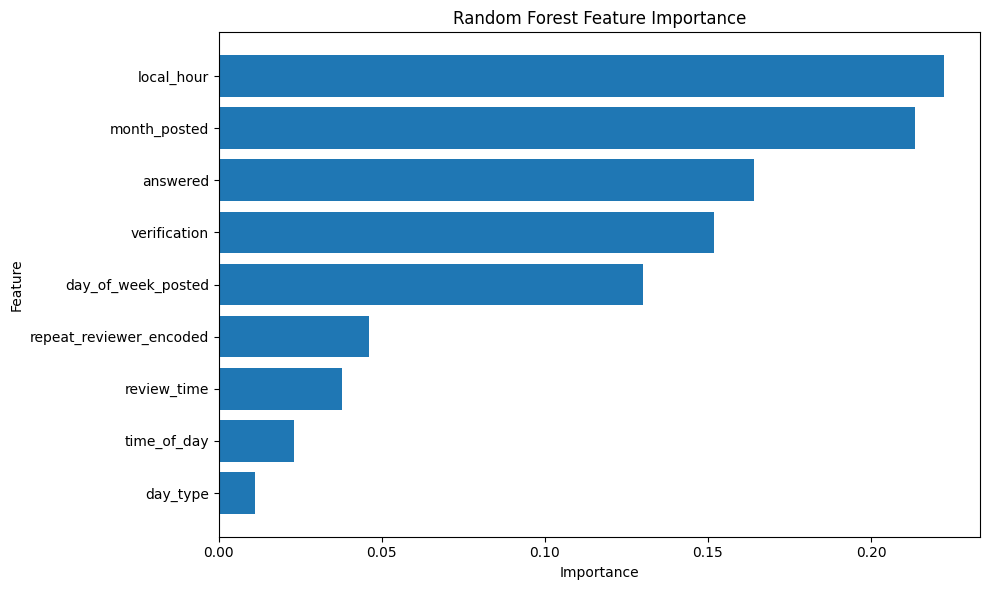

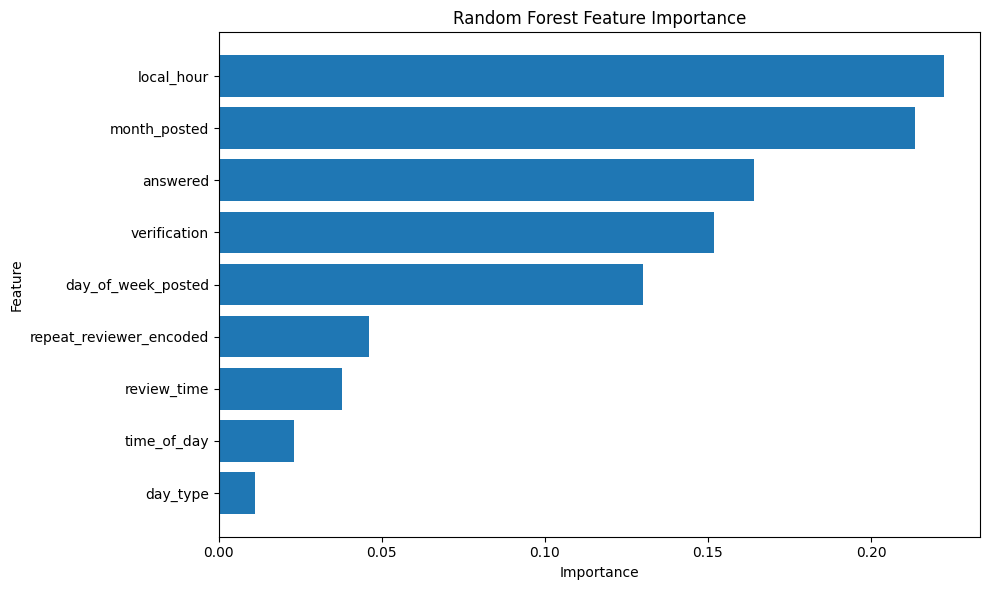

In [18]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
import numpy as np
import pandas as pd

def analyze_random_forest_importance():
    # Get numeric features excluding the target
    numeric_data = train_df.select_dtypes(include=['int64', 'float64'])
    X = numeric_data.drop('rating', axis=1)
    y = train_df['rating']

    # Scale the features
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    
    # Initialize and fit Random Forest
    rf = RandomForestClassifier(
        n_estimators=100,
        max_depth=None,
        min_samples_split=2,
        min_samples_leaf=1,
        n_jobs=-1,
        random_state=42
    )
    
    rf.fit(X_scaled, y)
    
    # Get feature importance scores
    importance_scores = rf.feature_importances_
    
    # Create DataFrame with features and their importance scores
    feature_importance = pd.DataFrame({
        'feature': X.columns,
        'importance': importance_scores
    })
    
    # Sort by importance
    feature_importance = feature_importance.sort_values('importance', ascending=False)
    
    # Calculate cumulative importance
    feature_importance['cumulative_importance'] = np.cumsum(feature_importance['importance'])
    
    # Find features that account for 95% of cumulative importance
    important_features = feature_importance[
        feature_importance['cumulative_importance'] <= 0.95
    ]['feature'].tolist()
    
    # Prepare output
    output = []
    output.append("Random Forest Feature Importance Analysis")
    output.append("=" * 50)
    
    # Model performance
    output.append("Model Performance:")
    output.append("-" * 50)
    train_score = rf.score(X_scaled, y)
    output.append(f"Training accuracy: {train_score:.4f}")
    
    # Feature importance details
    output.append("Feature Importance Rankings:")
    output.append("-" * 50)
    for idx, row in feature_importance.iterrows():
        output.append(
            f"{row['feature']}: "
            f"{row['importance']:.4f} "
            f"(Cumulative: {row['cumulative_importance']:.4f})"
        )
    
    # Features accounting for 95% of importance
    output.append("Key Features (95% of cumulative importance):")
    output.append("-" * 50)
    for feature in important_features:
        output.append(f"- {feature}")
    
    # Low importance features
    low_importance_features = feature_importance[
        ~feature_importance['feature'].isin(important_features)
    ]['feature'].tolist()
    
    output.append("Recommendations:")
    output.append("-" * 50)
    if low_importance_features:
        output.append("Consider removing these low-importance features:")
        for feature in low_importance_features:
            importance = feature_importance[
                feature_importance['feature'] == feature
            ]['importance'].values[0]
            output.append(f"- {feature} (importance: {importance:.4f})")
    
    # Additional insights
    output.append("Additional Insights:")
    output.append("-" * 50)
    output.append(f"Top 3 most important features account for "
                 f"{feature_importance['importance'][:3].sum():.1%} of total importance")
    output.append(f"Number of features needed for 95% importance: {len(important_features)}")
    
    return "".join(output)

# Run the analysis
from IPython.display import HTML, display
display(HTML(f"<pre>{analyze_random_forest_importance()}</pre>"))

# Optional: Create visualization of feature importance
def plot_feature_importance():
    """
    Create a visualization of feature importance
    Returns a matplotlib figure
    """
    import matplotlib.pyplot as plt
    
    # Run the analysis to get feature importance
    numeric_data = train_df.select_dtypes(include=['int64', 'float64'])
    X = numeric_data.drop('rating', axis=1)
    y = train_df['rating']
    
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    
    rf = RandomForestClassifier(n_estimators=100, random_state=42)
    rf.fit(X_scaled, y)
    
    # Create feature importance DataFrame
    importance_df = pd.DataFrame({
        'feature': X.columns,
        'importance': rf.feature_importances_
    }).sort_values('importance', ascending=True)
    
    # Create plot
    plt.figure(figsize=(10, 6))
    plt.barh(importance_df['feature'], importance_df['importance'])
    plt.xlabel('Importance')
    plt.ylabel('Feature')
    plt.title('Random Forest Feature Importance')
    plt.tight_layout()
    
    return plt.gcf()

display(plot_feature_importance())

STAGE 13 - LOGISTIC REGRESSION WITH RIB RATIO STUDY

In [19]:
#Logistic regression with rib ratio study


def analyze_variable_importance(column_name):
    if column_name not in train_df.columns:
        return f"Error: Column '{column_name}' not found in dataframe"
    
    y = (train_df['rating'] >= 4).astype(int)
    
    X = train_df[column_name]
    
    if not np.issubdtype(X.dtype, np.number):
        return f"Error: Column '{column_name}' is not numeric. Please encode categorical variables first."
    
    X = X.values.reshape(-1, 1)
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    # Fit logistic regression
    model = LogisticRegression(random_state=42)
    model.fit(X_train, y_train)
    
    # Make predictions
    y_pred_proba = model.predict_proba(X_test)[:, 1]
    y_pred = model.predict(X_test)
    
    # Calculate ROC curve
    fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
    roc_auc = auc(fpr, tpr)
    
    # Calculate correlation (point biserial for binary vs continuous)
    correlation, p_value = stats.pointbiserialr(y, X.ravel())
    
    output = []
    output.append(f"Variable Importance Analysis: {column_name} vs High/Low Rating")
    output.append("=" * 60)
    
    # Basic statistics
    output.append("Basic Statistics:")
    output.append(f"Mean value for low ratings: {X[y==0].mean():.3f}")
    output.append(f"Mean value for high ratings: {X[y==1].mean():.3f}")
    output.append(f"Correlation coefficient: {correlation:.3f}")
    output.append(f"P-value: {p_value:.3e}")
    
    # Logistic Regression Results
    output.append("Logistic Regression Results:")
    output.append(f"Coefficient: {model.coef_[0][0]:.3f}")
    output.append(f"Intercept: {model.intercept_[0]:.3f}")
    output.append(f"ROC AUC Score: {roc_auc:.3f}")
    
    # Classification Report
    output.append("Classification Report:")
    output.append(classification_report(y_test, y_pred))
    
    # Effect interpretation
    output.append("Interpretation:")
    if abs(correlation) < 0.1:
        strength = "negligible"
    elif abs(correlation) < 0.3:
        strength = "weak"
    elif abs(correlation) < 0.5:
        strength = "moderate"
    else:
        strength = "strong"
    
    direction = "positive" if correlation > 0 else "negative"
    
    output.append(f"- The relationship is {strength} and {direction}")
    if p_value < 0.05:
        output.append("- The relationship is statistically significant")
        output.append(f"- As {column_name} increases, the likelihood of a high rating")
        output.append(f"  {'increases' if correlation > 0 else 'decreases'}")
    else:
        output.append("- The relationship is not statistically significant")
    
    output.append(f"- The model has an ROC AUC of {roc_auc:.3f}, indicating")
    if roc_auc < 0.6:
        output.append("  poor predictive power")
    elif roc_auc < 0.7:
        output.append("  fair predictive power")
    elif roc_auc < 0.8:
        output.append("  good predictive power")
    else:
        output.append("  excellent predictive power")
    
    output.append("Keep for model training: ")
    output.append("Yes" if (p_value < 0.05 and roc_auc > 0.6) else "Consider dropping")
    
    return "".join(output)

# Get numeric columns excluding rating
numeric_columns = train_df.select_dtypes(include=['int64', 'float64']).columns
numeric_columns = [col for col in numeric_columns if col != 'rating']

print("Starting variable importance analysis...")
print("=" * 80)

# Loop through each numeric column
for column in numeric_columns:
    display(HTML(f"<pre>{analyze_variable_importance(column)}</pre>"))
    display(HTML("<hr>"))

Starting variable importance analysis...


STAGE 14 - VALIDATE AND COMPARE METHODS

Normalizing scores...
Generating recommendations...

Analysis Summary:



Detailed Results:


,feature,pearson,spearman,mutual_info,random_forest,lasso,mean_score,score_std,recommendation
0,verification,1.000000,0.977196,0.935321,0.665722,1.000000,0.915648,0.142187,Strong Keep
1,repeat_reviewer_encoded,0.571836,0.581700,0.194260,0.165214,0.160860,0.334774,0.221309,Consider Keeping
2,answered,0.905497,1.000000,1.000000,0.723812,0.607778,0.847417,0.175101,Strong Keep
3,month_posted,0.040617,0.000000,0.073488,0.957808,0.109830,0.236349,0.405341,Review (Conflicting Results)
4,local_hour,0.194591,0.163582,0.108290,1.000000,0.012807,0.295854,0.399646,Consider Keeping
5,time_of_day,0.000000,0.038857,0.008142,0.055754,0.032504,0.027052,0.022816,Consider Removing
6,day_of_week_posted,0.226976,0.206886,0.000000,0.562843,0.000000,0.199341,0.230450,Consider Keeping
7,day_type,0.306501,0.313817,0.022569,0.000000,0.210335,0.170644,0.151308,Consider Keeping
8,review_time,0.239595,0.281190,0.123855,0.126204,0.307752,0.215719,0.086282,Consider Keeping



Feature Importance Heatmap:


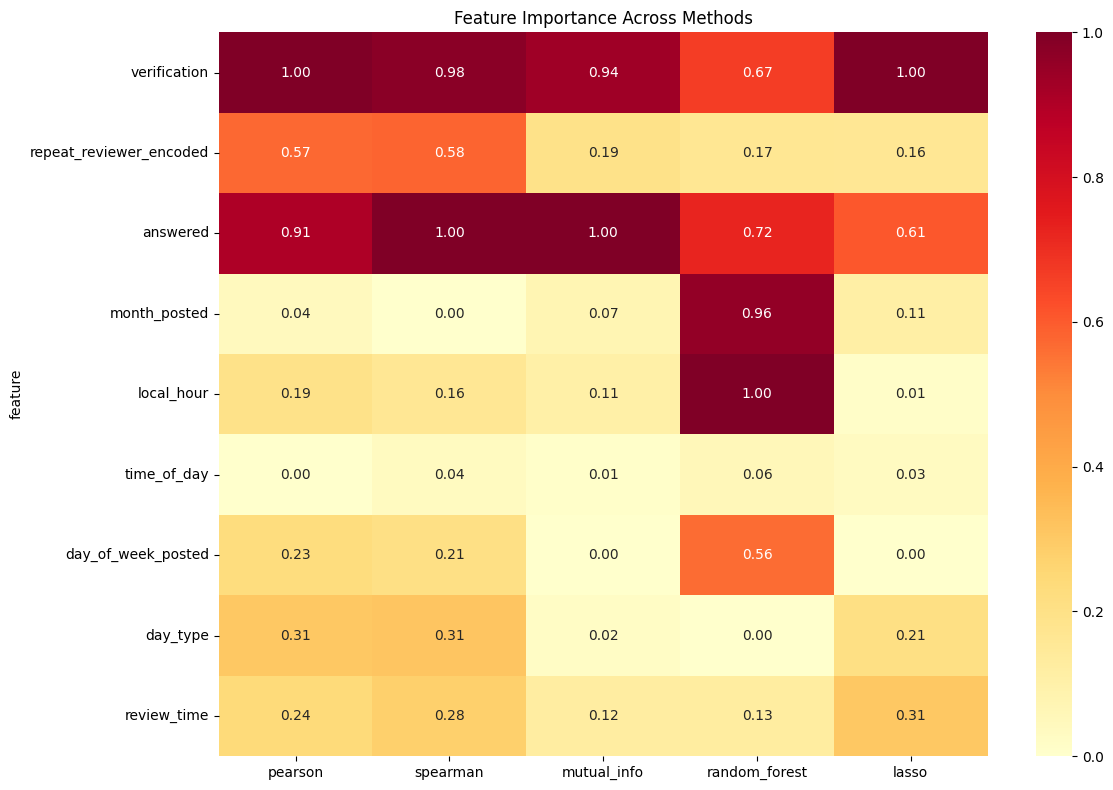

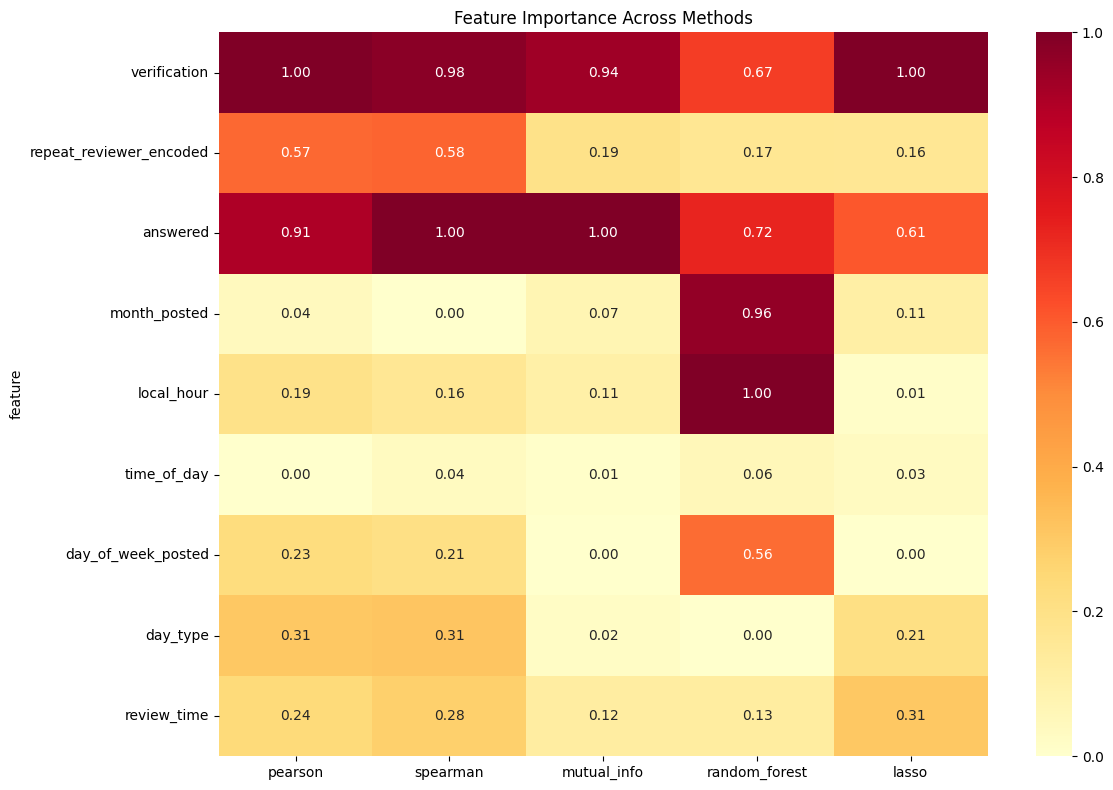

In [20]:
import pandas as pd
import numpy as np
from scipy.stats import pearsonr, spearmanr
from sklearn.feature_selection import mutual_info_regression
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LassoCV
from sklearn.preprocessing import StandardScaler
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import HTML, display

def collect_all_scores(df, target_col='rating'):
    # Get feature columns (numeric only)
    features = df.select_dtypes(include=['int64', 'float64']).columns
    features = [col for col in features if col != target_col]
    
    # Initialize results dictionary
    scores = {
        'feature': features,
        'pearson': [],
        'spearman': [],
        'mutual_info': [],
        'random_forest': [],
        'lasso': []
    }
    
    # Prepare data
    X = df[features]
    y = df[target_col]
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    
    # Calculate scores for each feature
    for feature in features:
        # Correlation scores
        pearson_coef, _ = pearsonr(df[feature], y)
        spearman_coef, _ = spearmanr(df[feature], y)
        
        scores['pearson'].append(abs(pearson_coef))
        scores['spearman'].append(abs(spearman_coef))
    
    # Mutual Information
    scores['mutual_info'] = mutual_info_regression(X, y)
    
    # Random Forest importance
    rf = RandomForestClassifier(n_estimators=100, random_state=42)
    rf.fit(X_scaled, y)
    scores['random_forest'] = rf.feature_importances_
    
    # Lasso importance
    lasso = LassoCV(cv=5, random_state=42)
    lasso.fit(X_scaled, y)
    scores['lasso'] = np.abs(lasso.coef_)
    
    # Convert to DataFrame
    scores_df = pd.DataFrame(scores)
    return scores_df

def normalize_scores(scores_df):
    # Get feature column
    features = scores_df['feature']
    
    # Normalize each method's scores
    methods = ['pearson', 'spearman', 'mutual_info', 'random_forest', 'lasso']
    normalized_scores = scores_df[methods].apply(lambda x: (x - x.min()) / (x.max() - x.min()) if x.max() != x.min() else x)
    
    # Add features back
    normalized_scores.insert(0, 'feature', features)
    
    return normalized_scores

def get_feature_recommendations(scores_df):
    # Calculate mean and std of scores for each feature
    score_cols = ['pearson', 'spearman', 'mutual_info', 'random_forest', 'lasso']
    scores_df['mean_score'] = scores_df[score_cols].mean(axis=1)
    scores_df['score_std'] = scores_df[score_cols].std(axis=1)
    
    # Generate recommendations
    def get_recommendation(row):
        if row['mean_score'] >= 0.7 and row['score_std'] < 0.2:
            return "Strong Keep"
        elif row['mean_score'] >= 0.4 and row['score_std'] < 0.3:
            return "Keep"
        elif row['mean_score'] >= 0.1 and row['score_std'] < 0.4:
            return "Consider Keeping"
        elif row['score_std'] >= 0.4:
            return "Review (Conflicting Results)"
        else:
            return "Consider Removing"
    
    scores_df['recommendation'] = scores_df.apply(get_recommendation, axis=1)
    return scores_df

def create_summary(final_scores):
    summary = []
    summary.append("Feature Selection Analysis Summary")
    summary.append("=" * 50)
    
    # Overall recommendations
    summary.append("\nRecommendations:")
    for recommendation in final_scores['recommendation'].unique():
        features = final_scores[final_scores['recommendation'] == recommendation]
        summary.append(f"\n{recommendation}:")
        for _, row in features.iterrows():
            summary.append(f"- {row['feature']} (mean score: {row['mean_score']:.3f})")
    
    return "\n".join(summary)

def plot_importance_heatmap(scores_df):
    plt.figure(figsize=(12, 8))
    score_cols = ['pearson', 'spearman', 'mutual_info', 'random_forest', 'lasso']
    heatmap_data = scores_df.set_index('feature')[score_cols]
    sns.heatmap(heatmap_data, annot=True, cmap='YlOrRd', fmt='.2f')
    plt.title('Feature Importance Across Methods')
    plt.tight_layout()
    return plt.gcf()

def analyze_features(df, target_col='rating'):
    # 1. Collect all scores
    print("Collecting scores from all methods...")
    scores = collect_all_scores(df, target_col)
    
    # 2. Normalize scores
    print("Normalizing scores...")
    normalized_scores = normalize_scores(scores)
    
    # 3. Generate recommendations
    print("Generating recommendations...")
    final_scores = get_feature_recommendations(normalized_scores)
    
    # 4. Create summary
    print("\nAnalysis Summary:")
    summary = create_summary(final_scores)
    display(HTML(f"<pre>{summary}</pre>"))
    
    # 5. Show detailed results
    print("\nDetailed Results:")
    display(final_scores.style
           .background_gradient(subset=['mean_score'])
           .set_caption("Feature Selection Results"))
    
    # 6. Show visualization
    print("\nFeature Importance Heatmap:")
    display(plot_importance_heatmap(normalized_scores))
    
    return final_scores

results = analyze_features(train_df)

Analyzing multicollinearity...

After multicollinearity handling:
Conservative features: ['verification', 'answered', 'repeat_reviewer_encoded', 'day_type', 'review_time', 'month_posted', 'local_hour']
Strict features: ['verification', 'answered', 'repeat_reviewer_encoded']

Validating feature sets...

Generating final importance ranking...

Multicollinearity Analysis Results:

Features removed due to multicollinearity:
- day_of_week_posted

Highly Correlated Feature Pairs:
day_type & day_of_week_posted: -0.738
Removed: day_of_week_posted


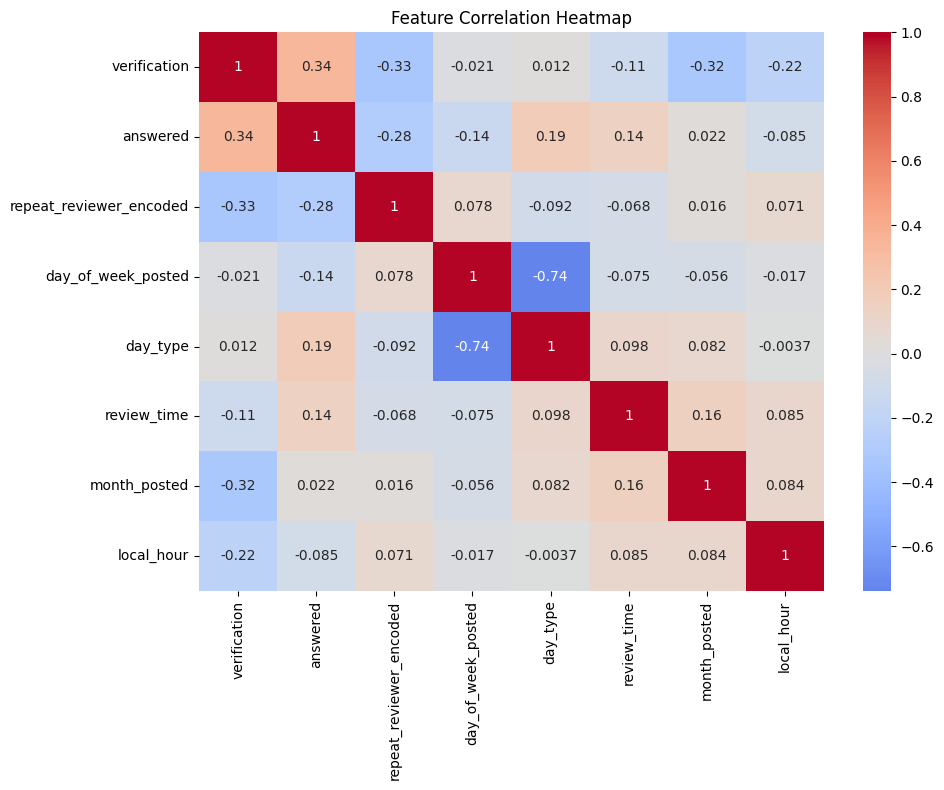


Feature Set Validation Results:

Conservative Approach:
------------------------------
Features: verification, answered, repeat_reviewer_encoded, day_type, review_time, month_posted, local_hour
accuracy: 0.583 (±0.002)
precision: 0.501 (±0.003)
recall: 0.583 (±0.002)
f1: 0.524 (±0.002)

Strict Approach:
------------------------------
Features: verification, answered, repeat_reviewer_encoded
accuracy: 0.590 (±0.003)
precision: 0.444 (±0.003)
recall: 0.590 (±0.003)
f1: 0.500 (±0.003)

Feature Importance Rankings:

Conservative Approach Importance:
------------------------------


,feature,importance
0,verification,0.230
1,answered,0.226
6,local_hour,0.218
5,month_posted,0.185
2,repeat_reviewer_encoded,0.058
4,review_time,0.053
3,day_type,0.031



Strict Approach Importance:
------------------------------


,feature,importance
1,answered,0.456
0,verification,0.430
2,repeat_reviewer_encoded,0.113



Feature Importance Comparison (Strict vs Conservative):
------------------------------
verification:
  Strict: 0.430
  Conservative: 0.230
  Change: 0.200
answered:
  Strict: 0.456
  Conservative: 0.226
  Change: 0.230
repeat_reviewer_encoded:
  Strict: 0.113
  Conservative: 0.058
  Change: 0.056


In [21]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import make_scorer, accuracy_score, precision_score, recall_score, f1_score
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.stats.outliers_influence import variance_inflation_factor

def analyze_final_features(df, target_col='rating', vif_threshold=5, corr_threshold=0.7):
    # Initial feature sets before multicollinearity check
    initial_features = {
        'conservative': [
            'verification', 
            'answered', 
            'repeat_reviewer_encoded',
            'day_of_week_posted',
            'day_type',
            'review_time',
            'month_posted',
            'local_hour'
        ],
        'strict': [
            'verification',
            'answered',
            'repeat_reviewer_encoded'
        ]
    }
    
    results = {}
    
    # 1. Check multicollinearity and get cleaned feature sets
    print("Analyzing multicollinearity...")
    multi_results = check_multicollinearity(df, initial_features['conservative'], 
                                          target_col, vif_threshold, corr_threshold)
    results['multicollinearity'] = multi_results
    
    # Update feature sets based on multicollinearity analysis
    cleaned_features = multi_results['cleaned_features']
    
    # Update conservative and strict approaches
    conservative_features = cleaned_features
    strict_features = [f for f in cleaned_features if f in initial_features['strict']]
    
    print("\nAfter multicollinearity handling:")
    print(f"Conservative features: {conservative_features}")
    print(f"Strict features: {strict_features}")
    
    # 2. Validate both feature sets
    print("\nValidating feature sets...")
    conservative_metrics = validate_feature_set(df, conservative_features, target_col)
    strict_metrics = validate_feature_set(df, strict_features, target_col)
    
    results['conservative'] = {
        'features': conservative_features,
        'metrics': conservative_metrics
    }
    results['strict'] = {
        'features': strict_features,
        'metrics': strict_metrics
    }
    
    # 3. Generate final importance ranking for both approaches
    print("\nGenerating final importance ranking...")
    importance_ranking = get_final_importance_ranking(df, conservative_features, strict_features, target_col)
    results['importance_ranking'] = importance_ranking
    
    # Display results
    display_comprehensive_results(results)
    
    return results

def check_multicollinearity(df, features, target_col, vif_threshold=5, corr_threshold=0.7):
    features_to_check = [f for f in features if f in df.columns]
    X = df[features_to_check]
    
    # Calculate initial VIF
    scaler = StandardScaler()
    X_scaled = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)
    
    vif_data = pd.DataFrame()
    vif_data["Feature"] = X_scaled.columns
    vif_data["VIF"] = [variance_inflation_factor(X_scaled.values, i) 
                       for i in range(X_scaled.shape[1])]
    
    # Calculate correlation matrix
    corr_matrix = X.corr()
    
    # Calculate correlation with target for importance assessment
    target_correlations = X.apply(lambda x: abs(x.corr(df[target_col])))
    
    # Find features to remove due to multicollinearity
    features_to_remove = set()
    
    # Check VIF
    high_vif_features = vif_data[vif_data["VIF"] > vif_threshold]["Feature"].tolist()
    if high_vif_features:
        # Remove features with highest VIF iteratively
        while len(high_vif_features) > 0:
            # Remove feature with highest VIF and lowest correlation with target
            worst_feature = min(high_vif_features, 
                              key=lambda x: target_correlations[x])
            features_to_remove.add(worst_feature)
            
            # Recalculate VIF without the removed feature
            remaining_features = [f for f in X.columns if f not in features_to_remove]
            if not remaining_features:
                break
                
            X_subset = X[remaining_features]
            X_scaled = pd.DataFrame(scaler.fit_transform(X_subset), 
                                  columns=X_subset.columns)
            
            vif_data = pd.DataFrame()
            vif_data["Feature"] = X_scaled.columns
            vif_data["VIF"] = [variance_inflation_factor(X_scaled.values, i) 
                              for i in range(X_scaled.shape[1])]
            
            high_vif_features = vif_data[vif_data["VIF"] > vif_threshold]["Feature"].tolist()
    
    # Check correlations
    high_corr_pairs = []
    for i in range(len(corr_matrix.columns)):
        for j in range(i):
            if abs(corr_matrix.iloc[i, j]) > corr_threshold:
                feat1 = corr_matrix.columns[i]
                feat2 = corr_matrix.columns[j]
                corr = corr_matrix.iloc[i, j]
                
                # Decide which feature to remove based on correlation with target
                if target_correlations[feat1] < target_correlations[feat2]:
                    features_to_remove.add(feat1)
                else:
                    features_to_remove.add(feat2)
                    
                high_corr_pairs.append({
                    'feature1': feat1,
                    'feature2': feat2,
                    'correlation': corr,
                    'removed': feat1 if target_correlations[feat1] < target_correlations[feat2] else feat2
                })
    
    # Get final cleaned feature set
    cleaned_features = [f for f in features if f not in features_to_remove]
    
    return {
        'vif': vif_data,
        'correlation_matrix': corr_matrix,
        'high_correlations': high_corr_pairs,
        'removed_features': list(features_to_remove),
        'cleaned_features': cleaned_features
    }

def validate_feature_set(df, features, target_col):
    X = df[features]
    y = df[target_col]
    
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    
    rf = RandomForestClassifier(n_estimators=100, random_state=42)
    
    scoring = {
        'accuracy': make_scorer(accuracy_score),
        'precision': make_scorer(precision_score, average='weighted'),
        'recall': make_scorer(recall_score, average='weighted'),
        'f1': make_scorer(f1_score, average='weighted')
    }
    
    metrics = {}
    for metric_name, scorer in scoring.items():
        cv_scores = cross_val_score(rf, X_scaled, y, scoring=scorer, cv=5)
        metrics[metric_name] = {
            'mean': cv_scores.mean(),
            'std': cv_scores.std()
        }
    
    return metrics

def get_final_importance_ranking(df, conservative_features, strict_features, target_col):
    X_conservative = df[conservative_features]
    X_strict = df[strict_features]
    y = df[target_col]
    
    scaler = StandardScaler()
    rf = RandomForestClassifier(n_estimators=100, random_state=42)
    
    # Get conservative approach importance
    X_cons_scaled = scaler.fit_transform(X_conservative)
    rf.fit(X_cons_scaled, y)
    conservative_importance = pd.DataFrame({
        'feature': conservative_features,
        'importance': rf.feature_importances_
    }).sort_values('importance', ascending=False)
    
    # Get strict approach importance
    X_strict_scaled = scaler.fit_transform(X_strict)
    rf.fit(X_strict_scaled, y)
    strict_importance = pd.DataFrame({
        'feature': strict_features,
        'importance': rf.feature_importances_
    }).sort_values('importance', ascending=False)
    
    return {
        'conservative': conservative_importance,
        'strict': strict_importance
    }

def display_comprehensive_results(results):

    print("\nMulticollinearity Analysis Results:")
    print("=" * 50)
    
    # Display removed features
    print("\nFeatures removed due to multicollinearity:")
    if results['multicollinearity']['removed_features']:
        for feature in results['multicollinearity']['removed_features']:
            print(f"- {feature}")
    else:
        print("No features removed")
    
    # Display high correlations
    print("\nHighly Correlated Feature Pairs:")
    if results['multicollinearity']['high_correlations']:
        for pair in results['multicollinearity']['high_correlations']:
            print(f"{pair['feature1']} & {pair['feature2']}: {pair['correlation']:.3f}")
            print(f"Removed: {pair['removed']}")
    else:
        print("No highly correlated pairs found")
    
    # Plot correlation heatmap for final features
    plt.figure(figsize=(10, 8))
    sns.heatmap(results['multicollinearity']['correlation_matrix'], 
                annot=True, cmap='coolwarm', center=0)
    plt.title('Feature Correlation Heatmap')
    plt.tight_layout()
    plt.show()
    
    # Display validation results
    print("\nFeature Set Validation Results:")
    print("=" * 50)
    
    print("\nConservative Approach:")
    print("-" * 30)
    print("Features:", ", ".join(results['conservative']['features']))
    for metric, scores in results['conservative']['metrics'].items():
        print(f"{metric}: {scores['mean']:.3f} (±{scores['std']:.3f})")
    
    print("\nStrict Approach:")
    print("-" * 30)
    print("Features:", ", ".join(results['strict']['features']))
    for metric, scores in results['strict']['metrics'].items():
        print(f"{metric}: {scores['mean']:.3f} (±{scores['std']:.3f})")
    
    # Display feature importance rankings
    print("\nFeature Importance Rankings:")
    print("=" * 50)
    
    print("\nConservative Approach Importance:")
    print("-" * 30)
    display(results['importance_ranking']['conservative'])
    
    print("\nStrict Approach Importance:")
    print("-" * 30)
    display(results['importance_ranking']['strict'])
    
    # Compare relative importance changes
    common_features = set(results['importance_ranking']['strict']['feature']) & \
                     set(results['importance_ranking']['conservative']['feature'])
    
    if common_features:
        print("\nFeature Importance Comparison (Strict vs Conservative):")
        print("-" * 30)
        for feature in common_features:
            strict_imp = results['importance_ranking']['strict'][
                results['importance_ranking']['strict']['feature'] == feature]['importance'].iloc[0]
            cons_imp = results['importance_ranking']['conservative'][
                results['importance_ranking']['conservative']['feature'] == feature]['importance'].iloc[0]
            print(f"{feature}:")
            print(f"  Strict: {strict_imp:.3f}")
            print(f"  Conservative: {cons_imp:.3f}")
            print(f"  Change: {(strict_imp - cons_imp):.3f}")


results = analyze_final_features(train_df)


STAGE 16 - SCALING/NORMALIZATION/STANDARDIZATION

In [ ]:
from sklearn.preprocessing import StandardScaler
import pandas as pd

def scale_features(train_df, test_df):
    # Identify columns that need scaling
    columns_to_scale = ['local_hour', 'time_of_day', 'day_of_week_posted', 'review_time']
    
    # Binary columns (0/1) - don't scale these
    binary_columns = ['verification', 'answered', 'repeat_reviewer_encoded', 'day_type']
    
    # Initialize scaler
    scaler = StandardScaler()
    
    # Create copies of the dataframes
    train_scaled = train_df.copy()
    test_scaled = test_df.copy()
    
    # Scale only the selected columns
    train_scaled[columns_to_scale] = scaler.fit_transform(train_df[columns_to_scale])
    test_scaled[columns_to_scale] = scaler.transform(test_df[columns_to_scale])
    
    return train_scaled, test_scaled, scaler

# Use the function
train_scaled, test_scaled, scaler = scale_features(train_df, test_df)

# Verify scaling results
print("\nTraining set statistics after scaling:")
print(train_scaled[['local_hour', 'time_of_day', 'day_of_week_posted', 'review_time']].describe())

STAGE 15 - DIMENSIONALITY REDUCTION

In [22]:
#Not needed as we have less than 20 features in our final selection

In [23]:
train_df.describe()

,rating,verification,repeat_reviewer_encoded,answered,local_date_posted,month_posted,local_hour,time_of_day,day_of_week_posted,day_type,review_time
count,62723.000,62723.000,62723.000,62723.000,62723,62723.00,62723.000,62723.000,62723.00,62723.000,62723.000
mean,3.521,0.646,0.438,0.248,2021-01-23 02:10:55.797713664,6.16,12.386,2.270,2.61,0.816,0.802
min,1.000,0.000,0.000,0.000,2009-06-09 00:00:00,1.00,0.000,0.000,0.00,0.000,0.000
25%,1.000,0.000,0.000,0.000,2019-08-14 00:00:00,3.00,9.000,2.000,1.00,1.000,1.000
50%,4.000,1.000,0.000,0.000,2021-11-14 00:00:00,5.00,12.000,3.000,2.00,1.000,1.000
75%,5.000,1.000,1.000,0.000,2023-05-14 00:00:00,9.00,16.000,3.000,4.00,1.000,1.000
max,5.000,1.000,1.000,1.000,2024-10-23 00:00:00,12.00,23.000,3.000,6.00,1.000,1.000
std,1.698,0.478,0.496,0.432,NaN,3.65,4.899,0.966,1.85,0.388,0.399


STAGE 17 - OVERSAMPLING/UNDERSAMPLING

In [25]:
print("Class distribution in training set:")
print(train_scaled['rating'].value_counts(normalize=True))

Class distribution in training set:
rating
5    0.497
1    0.252
4    0.095
3    0.092
2    0.064
Name: proportion, dtype: float64


In [26]:
import numpy as np
import pandas as pd
from sklearn.utils import resample

def apply_balancing_methods(X_train, y_train, random_state=42):
    """
    Apply different balancing methods without external packages
    """
    results = {}
    
    # Store original data
    results['original'] = (X_train.copy(), y_train.copy())
    
    # 1. Random Oversampling
    # Identify minority classes and oversample each
    X_over = pd.DataFrame()
    y_over = pd.Series()
    target_size = y_train.value_counts().max()
    
    for class_value in y_train.unique():
        # Get indices for this class
        class_indices = y_train == class_value
        X_class = X_train[class_indices]
        y_class = y_train[class_indices]
        
        # If this is a minority class, oversample it
        if len(y_class) < target_size:
            X_resampled = resample(X_class, 
                                 n_samples=target_size,
                                 random_state=random_state)
            y_resampled = pd.Series([class_value] * target_size)
        else:
            X_resampled = X_class
            y_resampled = y_class
            
        X_over = pd.concat([X_over, X_resampled])
        y_over = pd.concat([y_over, y_resampled])
    
    results['oversampling'] = (X_over, y_over)
    
    # 2. Random Undersampling
    # Undersample majority classes to match minority class size
    X_under = pd.DataFrame()
    y_under = pd.Series()
    target_size = y_train.value_counts().min()
    
    for class_value in y_train.unique():
        # Get indices for this class
        class_indices = y_train == class_value
        X_class = X_train[class_indices]
        y_class = y_train[class_indices]
        
        # If this is a majority class, undersample it
        if len(y_class) > target_size:
            X_resampled = resample(X_class,
                                 n_samples=target_size,
                                 random_state=random_state)
            y_resampled = pd.Series([class_value] * target_size)
        else:
            X_resampled = X_class
            y_resampled = y_class
            
        X_under = pd.concat([X_under, X_resampled])
        y_under = pd.concat([y_under, y_resampled])
    
    results['undersampling'] = (X_under, y_under)
    
    # 3. Class Weights
    # Calculate class weights inversely proportional to class frequencies
    class_weights = dict(zip(
        np.unique(y_train),
        1/(np.bincount(y_train)[np.unique(y_train)])
    ))
    results['class_weights'] = class_weights
    
    return results

def print_distributions(results):
    """Print class distributions for each method"""
    print("Original class distribution:")
    print(results['original'][1].value_counts(normalize=True))
    
    print("\nOversampled class distribution:")
    print(results['oversampling'][1].value_counts(normalize=True))
    
    print("\nUndersampled class distribution:")
    print(results['undersampling'][1].value_counts(normalize=True))
    
    print("\nClass weights for weighted approach:")
    print(results['class_weights'])

# Apply the balancing methods
X = train_scaled.drop('rating', axis=1)
y = train_scaled['rating']

# Get balanced datasets
results = apply_balancing_methods(X, y)

# Print distributions
print_distributions(results)

# Store results for later use
balanced_datasets = {
    'original': results['original'],
    'oversampling': results['oversampling'],
    'undersampling': results['undersampling'],
    'class_weights': results['class_weights']
}

Original class distribution:
rating
5    0.497
1    0.252
4    0.095
3    0.092
2    0.064
Name: proportion, dtype: float64

Oversampled class distribution:
5    0.2
3    0.2
1    0.2
4    0.2
2    0.2
Name: proportion, dtype: float64

Undersampled class distribution:
5    0.2
3    0.2
1    0.2
4    0.2
2    0.2
Name: proportion, dtype: float64

Class weights for weighted approach:
{1: 6.328312871788382e-05, 2: 0.0002486325211337643, 3: 0.00017340038148083925, 4: 0.00016728002676480428, 5: 3.209860692045965e-05}


STAGE 18 - CROSS-VALIDATION

In [27]:
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
import pandas as pd
import numpy as np

def evaluate_feature_set(X, y, balanced_datasets, feature_set_name, random_state=42):
    """
    Evaluate one feature set (Conservative or Strict) with different preprocessing methods
    """
    results = []
    
    # Try each sampling method
    for sampling_method in ['original', 'oversampling', 'undersampling']:
        # Get the appropriate dataset
        X_sampled = balanced_datasets[sampling_method][0][X.columns]
        y_sampled = balanced_datasets[sampling_method][1]
        
        # Basic Random Forest without class weights
        rf = RandomForestClassifier(n_estimators=100, random_state=random_state)
        scores = cross_val_score(rf, X_sampled, y_sampled, cv=5, scoring='accuracy')
        
        results.append({
            'Preprocessing Method': sampling_method,
            'Weight Method': 'None',
            'Mean CV Score': scores.mean(),
            'Std CV Score': scores.std()
        })
    
    # Try with class weights
    rf_weighted = RandomForestClassifier(
        n_estimators=100,
        class_weight=balanced_datasets['class_weights'],
        random_state=random_state
    )
    scores = cross_val_score(rf_weighted, X, y, cv=5, scoring='accuracy')
    
    results.append({
        'Preprocessing Method': 'original',
        'Weight Method': 'class_weights',
        'Mean CV Score': scores.mean(),
        'Std CV Score': scores.std()
    })
    
    results_df = pd.DataFrame(results).sort_values('Mean CV Score', ascending=False)
    
    print(f"\n{feature_set_name} Feature Set Results:")
    print("=" * 50)
    print(results_df)
    
    best_method = results_df.iloc[0]
    print(f"\nBest preprocessing for {feature_set_name}:")
    print(f"Method: {best_method['Preprocessing Method']}")
    print(f"Weights: {best_method['Weight Method']}")
    print(f"Score: {best_method['Mean CV Score']:.3f} (±{best_method['Std CV Score']:.3f})")
    
    return results_df

# Prepare conservative and strict feature sets
conservative_features = ['verification', 'answered', 'repeat_reviewer_encoded', 
                        'day_of_week_posted', 'day_type', 'review_time', 
                        'month_posted', 'local_hour']

strict_features = ['verification', 'answered', 'repeat_reviewer_encoded']

# Evaluate each feature set separately
X_conservative = train_scaled[conservative_features]
X_strict = train_scaled[strict_features]
y = train_scaled['rating']

# Get results for both approaches
conservative_results = evaluate_feature_set(X_conservative, y, balanced_datasets, "Conservative")
strict_results = evaluate_feature_set(X_strict, y, balanced_datasets, "Strict")

# Compare best results from each feature set
print("\nFinal Comparison:")
print("=" * 50)
best_conservative = conservative_results.iloc[0]
best_strict = strict_results.iloc[0]

print("\nBest Conservative Setup:")
print(f"Preprocessing: {best_conservative['Preprocessing Method']}")
print(f"Weights: {best_conservative['Weight Method']}")
print(f"Score: {best_conservative['Mean CV Score']:.3f} (±{best_conservative['Std CV Score']:.3f})")

print("\nBest Strict Setup:")
print(f"Preprocessing: {best_strict['Preprocessing Method']}")
print(f"Weights: {best_strict['Weight Method']}")
print(f"Score: {best_strict['Mean CV Score']:.3f} (±{best_strict['Std CV Score']:.3f})")

if best_conservative['Mean CV Score'] > best_strict['Mean CV Score']:
    winner = "Conservative"
    margin = best_conservative['Mean CV Score'] - best_strict['Mean CV Score']
else:
    winner = "Strict"
    margin = best_strict['Mean CV Score'] - best_conservative['Mean CV Score']

print(f"\nOverall Winner: {winner} feature set")
print(f"Performance margin: {margin:.3f}")


Conservative Feature Set Results:
  Preprocessing Method  Weight Method  Mean CV Score  Std CV Score
1         oversampling           None          0.573         0.002
0             original           None          0.561         0.004
3             original  class_weights          0.470         0.002
2        undersampling           None          0.427         0.010

Best preprocessing for Conservative:
Method: oversampling
Weights: None
Score: 0.573 (±0.002)

Strict Feature Set Results:
  Preprocessing Method  Weight Method  Mean CV Score  Std CV Score
0             original           None          0.590     2.959e-03
3             original  class_weights          0.467     8.193e-04
2        undersampling           None          0.376     6.089e-03
1         oversampling           None          0.376     1.132e-03

Best preprocessing for Strict:
Method: original
Weights: None
Score: 0.590 (±0.003)

Final Comparison:

Best Conservative Setup:
Preprocessing: oversampling
Weights: None

In [28]:
import os
os.makedirs('data', exist_ok=True)

# Determine winning approach from cross-validation
best_conservative = conservative_results.iloc[0]
best_strict = strict_results.iloc[0]

# Save the winning approach
if best_conservative['Mean CV Score'] > best_strict['Mean CV Score']:
    winning_cols = ['verification', 'answered', 'repeat_reviewer_encoded',
                   'day_of_week_posted', 'day_type', 'review_time',
                   'month_posted', 'local_hour', 'rating']
else:
    winning_cols = ['verification', 'answered', 'repeat_reviewer_encoded', 'rating']

# Save datasets
df_trustpilot.to_csv('data/data_trustpilot_4.csv', index=False)
train_df[winning_cols].to_csv('data/train_4.csv', index=False)
test_df[winning_cols].to_csv('data/test_4.csv', index=False)